In [305]:
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
import plotnine as p9

The goal of Cox regression model is to asses the relationship of predictor variables to survival time of a certain event.

## Introduction

We start by creating a simple simulated data set for survival models. The data consists of 5 subjects, labelled A to E. Each subject either:

- underwent a preventive treatment (x = 1) or did not (x = 0) prior to the study
- got a disease (event = 1) or not (event = 0) during the duration of the study

If a subject got a disease, then time lists the timepoint at which they got a disease. If they did not acquire a disease at any time we checked in with them during the study, we will list as time the last time point when we checked in with them (here we make it a timepoint 6), and label event = 0.

In other words, x is our only predictor variable, and event is there only to keep track of subjects that did not acquire a disease during the duration of the study ("censored"). If the study is long enough to catch everyone getting a disease, then the event column is technically redundant. Although, statistical packages for Cox regression will typically still want it.

Our goal is here is to evaluate whether the preventive treatment (x) increases survival time, i.e. the time duration before getting a disease.

In [237]:
sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 5, 4, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [0, 0, 0, 1, 1],
})

sample_df

,subject,time,event,x
0,A,1,1,0
1,B,3,1,0
2,C,5,1,0
3,D,4,1,1
4,E,6,0,1


In order to better visualize the events of getting a disease in this table, we can plot the data:

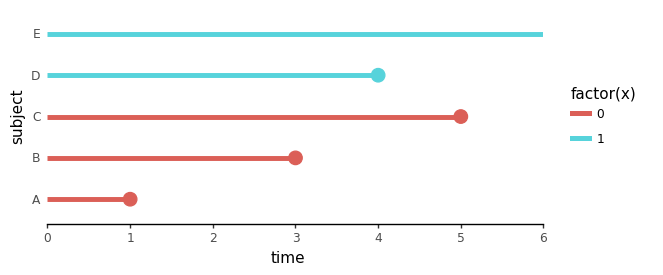

<ggplot: (8755737155711)>

In [346]:
def plot_eventtimes_per_subject(df, color_map='factor(x)'):
    return (
        p9.ggplot(
            df, p9.aes(x='time', y='subject', color=color_map)
        )
        + p9.geom_segment(
            p9.aes(x=0, xend='time', yend='subject'), size=2
        )
        + p9.geom_point(data=df[df['event'] == 1], shape='o', size=5, show_legend=False)
        + p9.scale_x_continuous(expand=[0, 0], breaks=range(7))
        + p9.coord_fixed(0.5)
        + p9.theme_classic()
        + p9.theme(
            axis_line_y=p9.element_blank(),
            axis_ticks_major_y=p9.element_blank()
        )
    )

plot_eventtimes_per_subject(sample_df)

On this plot, lines indicate the duration of time each subject experienced before getting a disease. The "getting a disease" event is marked with a filled circle. Subject E does not have a circle since it "survived" the entire study without getting a disease (experiencing an event). Teal colors are used for subjects D and E, who had gotten a preventive treatment (x = 1). Red colors are for subjects A, B and C who had not gotten a preventive treatment (x = 0).

## Hazards

**Hazard is a probability of event occurence per unit time**, or a rate at which events are occurring. Hazard has units of inverse time and its values can range between zero and infinity (e.g. 500 events per second), unlike probability - which is between 0 and 1. In a general case, hazard can also change with time. For example, when event is "diagnosed with cancer", hazard increases with time.

In Cox regression, hazard $h(t, x)$ is modeled in a similar spirit to odds in logistic regression. In logistic regression, odds p/(1-p) was used to create a variable that has a range $[0, \infty)$, since probabilities range $[0, 1]$. Then, logarithm was used to transform odds to values within an interval $(-\infty, \infty)$. Here, logarithm is used to transform hazard's range of values $[0, \infty)$ to $(-\infty, \infty)$, for which linear regression makes more sense:

$$
\log h(t, x) = \beta x + \beta_0
$$

The main assumption of Cox regression is that any time dependence in log-hazard is part of the intercept term, $\beta_0(t)$:

$$
\log h(t, x) = \beta x + \beta_0(t)
$$

As we will see later, this assumption significantly simplifies the fitting process, although it may or may not be true. Across the literature, the intercept term is moved to the left side of the equation and instead expressed as a _baseline hazard_ $h_0(t)$:

$$
\log\left[\frac{h(t, x)}{h_0(t)}\right] = \beta x
$$

From this the hazard $h(t, x)$ can be expressed as:

$$
h(t, x) = h_0(t) e^{\beta x}
$$

This expression does not seem particularly useful. Unless we now also come up with some expression of how the baseline hazard $h_0(t)$ changes with time, it seems like we cannot actually do anything?

## Fitting

It turns out, we can leave this pesky term $h_0(t)$ undefined, as it can completely cancel out when fitting a model using a technique called Maximum Likelihood Estimation (short: MLE)!

In [241]:
def log_likelihood(df, subject, beta):
    subject_df = df[(df['subject'] == subject) & (df['event'] == 1)]
    if len(subject_df) == 0: # check if subject is censored
        return(0)
    event_time = subject_df['time'].iloc[0]
    at_risk_df = df[df['time'] >= event_time]
    subject_log_hazard = beta * subject_df['x'].iloc[0]
    total_at_risk_hazards = np.exp(beta * at_risk_df['x']).sum()
    return(subject_log_hazard - np.log(total_at_risk_hazards))


In [242]:
def neg_log_likelihood_all_subjects(df, beta):
    subjects = df['subject'].unique()
    neg_log_likelihoods = [-log_likelihood(df, subject, beta) for subject in subjects]
    return(
        pd.DataFrame({
            'subject': subjects,
            'neg_log_likelihood': neg_log_likelihoods
        })
    )

In [243]:
def neg_log_likelihood_all_subjects_betas(df, betas=np.arange(-5, 5, 0.5)):
    loglikelihoods_per_beta = []
    for beta in betas:
        beta_df = neg_log_likelihood_all_subjects(df, beta)
        beta_df.insert(0, 'beta', beta)
        loglikelihoods_per_beta.append(beta_df)
    return(pd.concat(loglikelihoods_per_beta))

In [244]:
negloglik_beta_df = neg_log_likelihood_all_subjects_betas(sample_df)
negloglik_beta_df.head(10)

,beta,subject,neg_log_likelihood
0,-5.0,A,1.103094
1,-5.0,B,0.699863
2,-5.0,C,0.006715
3,-5.0,D,5.013386
4,-5.0,E,0.000000
0,-4.5,A,1.105991
1,-4.5,B,0.704195
2,-4.5,C,0.011048
3,-4.5,D,4.521975
4,-4.5,E,0.000000


In [329]:
def plot_cost_vs_beta(df, betas=np.arange(-5, 5.5, 0.1)):
    negloglik_beta_df = neg_log_likelihood_all_subjects_betas(df, betas)
    return (
        p9.ggplot(negloglik_beta_df, p9.aes('beta', 'neg_log_likelihood', fill='subject'))
        + p9.geom_col(width=betas[1]-betas[0])
        + p9.scale_x_continuous(expand=[0, 0])
        + p9.scale_y_continuous(name='negative log-likelihoods ("cost")', expand=[0, 0])
        + p9.theme_classic()
    )

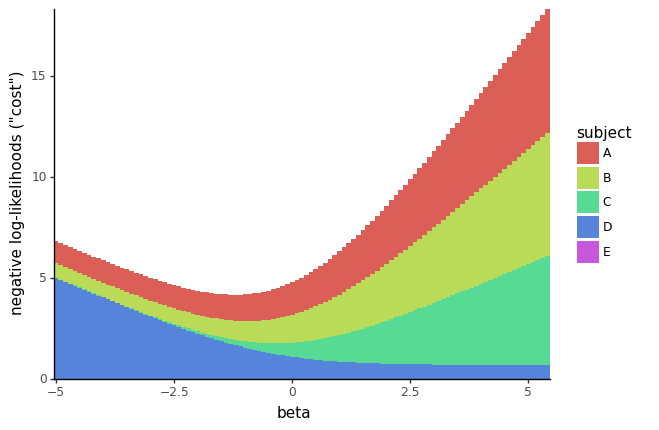

<ggplot: (8755738041947)>

In [330]:
plot_cost_vs_beta(sample_df)

Large bars = small likelihoods

If $\beta$ is negative, then the hazards of subjects with x = 1 (A, B, C) get suppressed

In [248]:
def total_log_likelihood(df, beta):
    subjects = df['subject'].unique()
    sum_log_likelihood = 0
    for subject in subjects:
        sum_log_likelihood += log_likelihood(df, subject, beta)
    return(sum_log_likelihood)

In [249]:
def total_loglik_vs_beta(df, betas=np.arange(-5, 5, 0.1)):
    total_log_likelihoods = [total_log_likelihood(df, beta) for beta in betas]
    return(
        pd.DataFrame({
            'beta': betas,
            'total_log_lik': total_log_likelihoods
        })
    )

In [250]:
fit_df = total_loglik_vs_beta(sample_df)
fit_df

,beta,total_log_lik
0,-5.0,-6.823058
1,-4.9,-6.726333
2,-4.8,-6.629949
3,-4.7,-6.533940
4,-4.6,-6.438346
...,...,...
95,4.5,-15.623602
96,4.6,-15.919423
97,4.7,-16.215638
98,4.8,-16.512209


In [341]:
cph = CoxPHFitter()
cph.fit(sample_df, duration_col='time', event_col='event', formula='x')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -4.17
         time fit was run = 2023-05-30 00:32:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -1.21       0.30       1.17            -3.51             1.09                 0.03                 2.98

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.03 0.30       1.72
---
Concordance = 0.70
Partial AIC = 10.35
log-likelihood ratio test = 1.23 on 1 df
-log2(p) of ll-ratio test = 1.90

## Continuous example

In [332]:
sample_cont_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 4, 5, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [0.1, 0.2, 0.3, 0.9, 1.2],
})

sample_cont_df

,subject,time,event,x
0,A,1,1,0.1
1,B,3,1,0.2
2,C,4,1,0.3
3,D,5,1,0.9
4,E,6,0,1.2


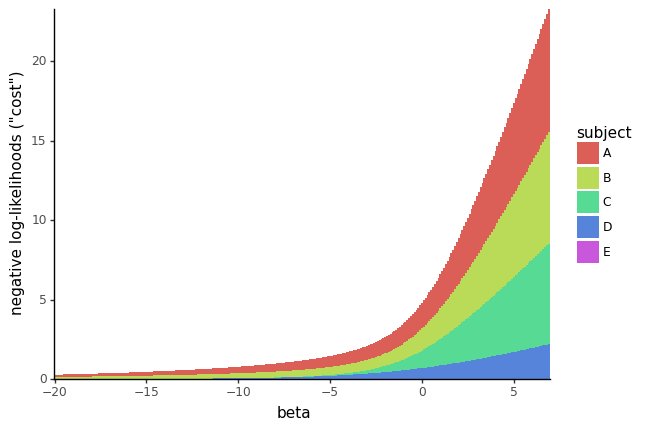

<ggplot: (8755739460012)>

In [334]:
plot_cost_vs_beta(sample_cont_df, betas=np.arange(-20, 7, 0.1))

In [ ]:
sample_cont_cox = CoxPHFitter()
sample_cont_cox.fit(sample_cont_df, )